# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model (Many-to-Many) and generating sequences (One-to-Many)

## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

## Import packages

In [ ]:
! pip install pretty_midi
import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation

import matplotlib.pyplot as plt
import numpy as np
import glob

     |████████████████████████████████| 5.6MB 10.4MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591954 sha256=63b8358eb9ae6db560f3cd0c7bea4360f05dac28659140972143eeeb6345bd66
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


# Get the data

In [ ]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [ ]:
DIR = './'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./cs1-2all.mid', './cs4-5bou.mid', './cs3-3cou.mid', './cs6-6gig.mid', './cs2-4sar.mid', './cs5-2all.mid', './cs5-6gig.mid', './cs2-5men.mid', './cs1-3cou.mid', './cs3-2all.mid', './cs3-1pre.mid', './cs1-5men.mid', './cs2-2all.mid', './cs2-6gig.mid', './cs5-3cou.mid', './cs3-4sar.mid', './cs5-4sar.mid', './cs6-5gav.mid', './cs1-6gig.mid', './cs4-6gig.mid', './cs4-3cou.mid', './cs6-3cou.mid', './cs1-1pre.mid', './cs5-1pre.mid', './cs6-2all.mid', './cs3-6gig.mid', './cs1-4sar.mid', './cs4-4sar.mid', './cs4-2all.mid', './cs2-3cou.mid', './cs6-4sar.mid', './cs2-1pre.mid', './cs5-5gav.mid', './cs3-5bou.mid', './cs4-1pre.mid', './cs6-1pre.mid']


## Read and convert all MIDI files

In [ ]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration

for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 59, start: 1.034805, end: 1.229610, duration: 0.194805
pitch: 59, start: 1.229610, end: 2.203637, duration: 0.974026
pitch: 57, start: 2.203637, end: 2.398442, duration: 0.194805
pitch: 55, start: 2.398442, end: 2.593247, duration: 0.194805
pitch: 54, start: 2.593247, end: 2.788052, duration: 0.194805
pitch: 55, start: 2.788052, end: 2.982858, duration: 0.194805
pitch: 50, start: 2.982858, end: 3.177663, duration: 0.194805
pitch: 52, start: 3.177663, end: 3.372468, duration: 0.194805
pitch: 54, start: 3.372468, end: 3.567273, duration: 0.194805
pitch: 55, start: 3.567273, end: 3.762079, duration: 0.194805
pitch: 57, start: 3.762079, end: 3.956884, duration: 0.194805
pitch: 59, start: 3.956884, end: 4.151689, duration: 0.194805
pitch: 60, start: 4.151689, end: 4.346494, duration: 0.194805
pitch: 62, start: 4.346494, end: 4.541300, duration: 0.194805
pitch: 59, start: 4.541300, end: 4.736105, duration: 0.194805
pitch: 55, start: 4.736105, end: 4.930910, duration: 0.194805
pitch: 5

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [ ]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(914, 79)
(1000, 79)
(984, 79)


## Display the set of notes over time for a specific track 

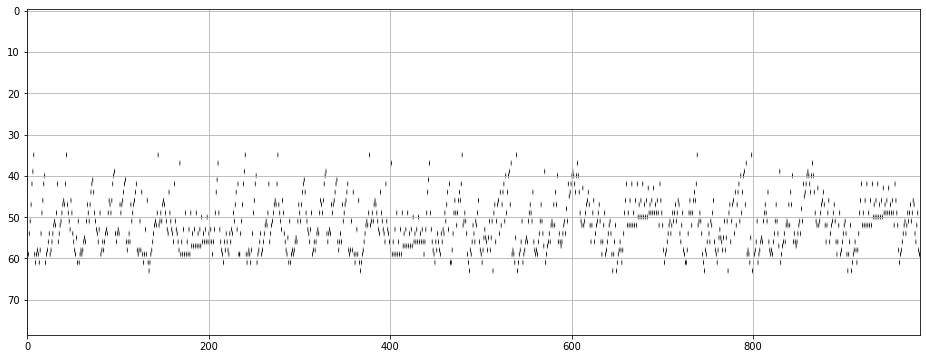

In [ ]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_02.png">


In [ ]:
X_train_list = []
y_train_list = []


for sequence in X_list:
  for subsequence in range(sequence.shape[0] - sequence_length):
    X_train_list.append(sequence[subsequence:subsequence + sequence_length])
    y_train_list.append(sequence[subsequence + sequence_length])

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23781, 20, 79)
y_train.shape: (23781, 79)


# Training the language model

The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

In [ ]:
# --- Create the model
K.clear_session()

n_a = 256
model = Sequential()
model.add(LSTM(units=n_a, return_sequences=True))
model.add(Dropout(rate=0.3))
model.add(LSTM(units=n_a, return_sequences=True))
model.add(Dropout(rate=0.3))
model.add(LSTM(units=n_a, return_sequences=False))
model.add(Dense(units=256))
model.add(Dropout(rate=0.3))
model.add(Dense(units=n_x, activation='softmax'))


In [ ]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
372/372 [==============================] - 4s 10ms/step - loss: 2.9289 - accuracy: 0.1149
Epoch 2/30
372/372 [==============================] - 4s 10ms/step - loss: 2.6065 - accuracy: 0.1638
Epoch 3/30
372/372 [==============================] - 4s 10ms/step - loss: 2.5241 - accuracy: 0.1876
Epoch 4/30
372/372 [==============================] - 4s 10ms/step - loss: 2.4502 - accuracy: 0.2244
Epoch 5/30
372/372 [==============================] - 4s 10ms/step - loss: 2.3644 - accuracy: 0.2651
Epoch 6/30
372/372 [==============================] - 4s 10ms/step - loss: 2.2545 - accuracy: 0.3049
Epoch 7/30
372/372 [==============================] - 4s 10ms/step - loss: 2.1217 - accuracy: 0.3520
Epoch 8/30
372/372 [==============================] - 4s 10ms/step - loss: 1.9852 - accuracy: 0.3935
Epoch 9/30
372/372 [==============================] - 4s 10ms/step - loss: 1.8356 - accuracy: 0.4380
Epoch 10/30
372/372 [==============================] - 4s 10ms/step - loss: 1.6675 - accura

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 23.781 sequences used for training.

- The ```pattern``` variable is the ```list``` of init notes to which we progressively append the new generated notes by the model.
- The ```prediction``` variable is a ```list``` which stores the softmax probability vector (a numpy array) corresponding to each generation time.


In [ ]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

12097
(20, 79)
(1, 20, 79)


In [ ]:
# --- note_l: is the list of notes (integer number) over time
note_l = []
# --- prediction_l: is the list of output-vectors (float numbers \in [0,1]) of the network over time
prediction_l = []
# --- Generate T_y_generated notes
for note_index in range(T_y_generated):
    prediction = model.predict(np.expand_dims(pattern, 0))
    predicted_note = np.argmax(prediction)
    note_l.append(predicted_note + 1)

    note_ohe = np.zeros(79)
    note_ohe[predicted_note] = 1
    
    pattern = np.vstack((pattern, note_ohe))
    pattern = np.delete(pattern, (0), axis=0)
    prediction_l.append(prediction) 


### Display the generated sequence

[51, 50, 51, 58, 54, 55, 57, 60, 55, 54, 60, 52, 50, 60, 52, 54, 60, 55, 57, 60, 55, 54, 60, 52, 50, 60, 52, 54, 60, 50, 58, 57, 55, 50, 55, 54, 55, 50, 46, 43, 51, 51, 50, 51, 46, 48, 50, 51, 50, 51, 55, 53, 55, 51, 50, 51, 46, 48, 50, 39, 55, 53, 51, 53, 58, 55, 56, 55, 53, 55, 51, 53, 55, 53, 51, 53, 58, 55, 56, 55, 53, 55, 51, 55, 53, 51, 50, 51, 60, 57, 58, 57, 55, 57, 53, 57, 53, 51, 50, 51, 60, 57, 58, 57, 55, 57, 53, 57, 51, 50, 48, 50, 62, 57, 58, 51, 50, 51, 62, 57, 58, 53, 51, 53, 62, 57, 58, 55, 53, 55, 62, 57, 58, 51, 50, 51, 48, 51, 46, 45, 51, 43, 45, 51, 41, 46, 50, 53, 58, 50, 53, 46, 58, 46, 39, 51, 51, 46, 51, 51, 46, 44, 43, 61, 51, 51, 48, 39, 44, 60, 43, 51, 51, 48, 48, 41, 42, 48, 46, 48, 51, 53, 56, 50, 56, 48, 50, 51, 50, 51, 55, 53, 51, 50, 48, 46, 44, 51, 53, 55]


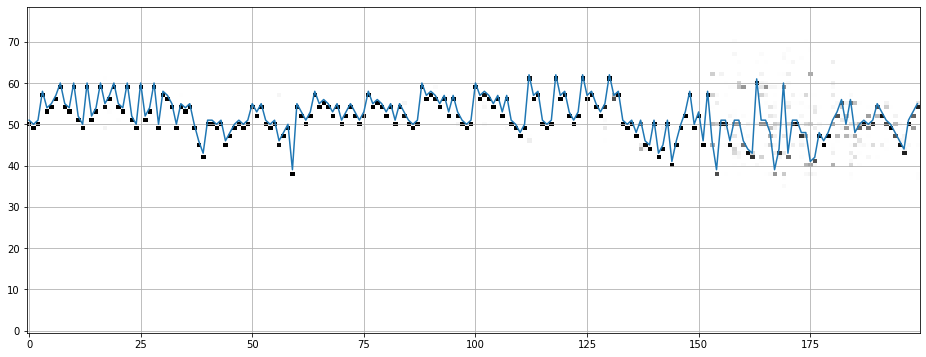

In [ ]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)


### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [ ]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

In [ ]:
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)